# GitHub RAG - Chat Service

In [37]:
from dotenv import load_dotenv

load_dotenv()

True

### LangChain 추적


In [38]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "RAG Chat Service"

In [39]:
from typing import TypedDict


# GraphState 요소는 상태를 전달하는 용도로 사용됩니다.
class GraphState(TypedDict):
    #answer1: str
    #answer2: str
    temp : int # 임시로 
    status: str  # 상태(재질문, 다음 작업, 종료)
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # 답변
    relevance: str  # 답변의 문서에 대한 관련성
    prompt : str

### [추가됨] Load Combined Documents from Local File(Store)

미리 저장해둔 Documents 파일에서 문서를 로드한다

In [40]:
import pickle

# 문서들을 로컬 파일에서 불러오는 함수
def load_documents_from_file(file_path):
    with open(file_path, 'rb') as f:
        documents = pickle.load(f)
    print(f"Documents loaded from {file_path}")
    return documents

# 저장된 문서들을 로컬 파일에서 불러오기
combined_documents = load_documents_from_file('./documents/combined_documents.pkl')

Documents loaded from ./documents/combined_documents.pkl


### Cached Embedding 불러오기

In [41]:
# langchain_openai와 langchain의 필요한 모듈들을 가져옵니다.
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

# 로컬 파일 저장소를 사용하기 위해 LocalFileStore 인스턴스를 생성합니다.
# './cache/' 디렉토리에 데이터를 저장합니다.
store = LocalFileStore("./cache/")

# OpenAI 임베딩 모델 인스턴스를 생성합니다. 모델명으로 "text-embedding-3-small"을 사용합니다.
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small", disallowed_special=())

# CacheBackedEmbeddings를 사용하여 임베딩 계산 결과를 캐시합니다.
# 이렇게 하면 임베딩을 여러 번 계산할 필요 없이 한 번 계산된 값을 재사용할 수 있습니다.
cached_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embeddings, store, namespace=embeddings.model
)

저장한 FAISS 데이터베이스를 불러옵니다. 이후 실행시에는 새롭게 DB 에 저장할 필요없이 아래 코드만 실행하면 됩니다.

In [42]:
# langchain_community 모듈에서 FAISS 클래스를 가져옵니다.
from langchain_community.vectorstores import FAISS

# 로컬에 저장된 FAISS 인덱스의 폴더 이름을 지정합니다.
FAISS_DB_INDEX = "langchain_faiss"

# FAISS 클래스의 load_local 메서드를 사용하여 저장된 벡터 인덱스를 로드합니다.
db = FAISS.load_local(
    FAISS_DB_INDEX,  # 로드할 FAISS 인덱스의 디렉토리 이름
    cached_embeddings,  # 임베딩 정보를 제공
    allow_dangerous_deserialization=True,  # 역직렬화를 허용하는 옵션
)


## Retriever


In [43]:
# langchain.retrievers 모듈에서 BM25Retriever 클래스를 가져옵니다.
from langchain.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever

ensemble_retriever = None

def retriever(state: GraphState) -> GraphState:
    global ensemble_retriever


    # MMR을 사용하여 검색을 수행하는 retriever를 생성합니다.
    faiss_retriever = db.as_retriever(search_type="mmr", search_kwargs={"k": 3})

    # 문서 컬렉션을 사용하여 BM25 검색 모델 인스턴스를 생성합니다.
    bm25_retriever = BM25Retriever.from_documents(
        combined_documents  # 초기화에 사용할 문서 컬렉션
    )

    # BM25Retriever 인스턴스의 k 속성을 10으로 설정하여,
    # 검색 시 최대 10개의 결과를 반환하도록 합니다.
    bm25_retriever.k = 3

    # langchain.retrievers 모듈에서 EnsembleRetriever 클래스를 가져옵니다.


    # EnsembleRetriever 인스턴스를 생성합니다.
    # 이때, BM25 검색 모델과 FAISS 검색 모델을 결합하여 사용합니다.
    ensemble_retriever = EnsembleRetriever(
        retrievers=[bm25_retriever, faiss_retriever],  # 사용할 검색 모델의 리스트
        weights=[0.6, 0.4],  # 각 검색 모델의 결과에 적용할 가중치
        search_type="mmr",  # 검색 결과의 다양성을 증진시키는 MMR 방식을 사용
    )

    ensemble_result =  ensemble_retriever.invoke(state["question"])

    if not isinstance(ensemble_result, str):
        ensemble_result = str(ensemble_result)

    return GraphState(question=state["question"], context=ensemble_result)






In [44]:

#ensemble_retriever.invoke("2024년 전망")

## 파이프라인 연결

chain 을 구성합니다.


### 프롬프트


In [45]:
from langchain_core.prompts import PromptTemplate

prompt = None

def prompt_write(state: GraphState) -> GraphState:

    prompt_write = """당신은 20년차 AI 개발자입니다. 당신의 임무는 주어진 질문에 대하여 최대한 문서의 정보를 활용하여 답변하는 것입니다.
    문서는 Python 코드에 대한 정보를 담고 있습니다. 따라서, 답변을 작성할 때에는 Python 코드에 대한 상세한 code snippet을 포함하여 작성해주세요.
    최대한 자세하게 답변하고, 한글로 답변해 주세요. 주어진 문서에서 답변을 찾을 수 없는 경우, "문서에 답변이 없습니다."라고 답변해 주세요.
    주어진 문서에 답변을 찾을수 있을때만 출처(source)에 "RAG에서 참조함" 이라고 답변해.

    #참고문서:
    {context}

    #질문:
    {question}

    #답변: 

    출처:
    - source1
    - source2
    - ...                             
    """
    return GraphState(prompt=prompt_write)


#prompt_write(0)

### LLM 정의


In [46]:
from langchain.callbacks.base import BaseCallbackHandler
from langchain_core.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.callbacks.manager import CallbackManager
from langchain_core.runnables import ConfigurableField
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.chat_models import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic


class StreamCallback(BaseCallbackHandler):
    def on_llm_new_token(self, token: str, **kwargs):
        print(token, end="", flush=True)


llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    streaming=True,
    callbacks=[StreamCallback()],
).configurable_alternatives(
    # 이 필드에 id를 부여합니다.
    # 최종 실행 가능한 객체를 구성할 때, 이 id를 사용하여 이 필드를 구성할 수 있습니다.
    ConfigurableField(id="llm"),
    # 기본 키를 설정합니다.
    default_key="gpt4",
    claude=ChatAnthropic(
        model="claude-3-5-sonnet-20240620",
        temperature=0,
        streaming=True,
        callbacks=[StreamCallback()],
    ),
    gpt3=ChatOpenAI(
        model="gpt-3.5-turbo",
        temperature=0,
        streaming=True,
        callbacks=[StreamCallback()],
    ),
    ollama=ChatOllama(
        model="llama3-korea",
        callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    ),
)




In [47]:
from langchain_upstage import UpstageGroundednessCheck

# 업스테이지 문서 관련성 체크 기능을 설정합니다. https://upstage.ai
upstage_ground_checker = UpstageGroundednessCheck()


def relevance_check(state: GraphState) -> GraphState:
    # 관련성 체크를 실행합니다. 결과: grounded, notGrounded, notSure
    response = upstage_ground_checker.run(
        {"context": state["context"], "answer": state["answer"]}
    )
    return GraphState(
       # relevance=response,
       # context=state["context"],
       # answer=state["answer"],
        status=state["status"]
    )

def is_relevant(state: GraphState) -> GraphState:
    return state["relevance"]

In [48]:
rag_chain = None

# 체인을 생성합니다.
def chain_create(state: GraphState) -> GraphState:
    global rag_chain
    
    context = state["context"]
    prompt = state["prompt"]

    rag_chain = (
        {"context": context, "question": RunnablePassthrough()} | prompt | llm | StrOutputParser()
    )
    return GraphState(status=state["status"])



## 질의-응답 테스트


In [49]:

def answers(state: GraphState) -> GraphState:

    
    answer = rag_chain.with_config(configurable={"llm": "gpt4"}).invoke(state["question"])

    return GraphState(status="A")




그래프 정의

In [50]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)


# Todo 를 작성합니다.
workflow.add_node("retriever", retriever) 
workflow.add_node("prompt_write", prompt_write) 
workflow.add_node("chain_create", chain_create) 
workflow.add_node("answers", answers) 
workflow.add_node("relevance_check", relevance_check)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.



# 각 노드들을 연결합니다.
workflow.add_edge("retriever", "prompt_write")
workflow.add_edge("prompt_write", "chain_create")
workflow.add_edge("chain_create", "answers")
workflow.add_edge("answers", "relevance_check")





# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "grounded": END,  # 관련성이 있으면 종료합니다.
        "notGrounded": "answers",  # 관련성이 없으면 다시 답변을 생성합니다.
        "notSure": "answers",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)


# 시작점을 설정합니다.
workflow.set_entry_point("retriever")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)



그래프화

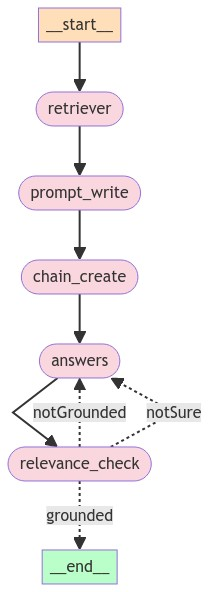

In [51]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
       # xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [52]:
# import pprint
# from langgraph.errors import GraphRecursionError
# from langchain_core.runnables import RunnableConfig

# config = RunnableConfig(recursion_limit=200, configurable={"thread_id": "TODO3"})

# inputs = GraphState(goal="랭체인기", status=0)

# output = app.invoke(inputs, config=config)


import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

# RunnableConfig 초기화
config = RunnableConfig(
    recursion_limit=100,  # 재귀 제한을 200으로 설정
    configurable={"thread_id": "TODO"}  # 적절한 thread_id로 대체
)



# 입력 데이터 설정 (goal 및 status 포함)
inputs: GraphState = {
    "question": "포토샵에 대해서 알려줘"
}


try:
    # app.invoke 호출
    output = app.invoke(inputs, config=config)
    # 결과 출력
    pprint.pprint(output)
except GraphRecursionError as e:
    # 재귀 한도 초과 예외 처리
    pprint.pprint(f"Recursion limit reached: {e}")
except Exception as e:
    # 기타 예외 처리
    pprint.pprint(f"Error during app.invoke: {e}")



"Error during app.invoke: unsupported operand type(s) for |: 'dict' and 'str'"
